# SISTER CWL submission
***

In [1]:
import json
import os
import xml.etree.ElementTree as ET
import pandas as pd
import requests
import IPython
from itertools import groupby
import datetime as dt 
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

In [2]:
def get_quicklook(job_id):
    result = maap.getJobResult(job_id)
    granule = result.outputs[0]
    return f'{granule}/{os.path.basename(granule)}.png'

### Load production list with scene URLs


In [4]:
scene_df = pd.read_csv('./sister_production_2_list.csv', encoding='utf-8-sig')
# Strip unicode character
scene_df.l1_granule = scene_df.l1_granule.map(lambda x: x.replace('\ufeff',''))
scene_df.tail()

,Instrument,Type,Area,Flight Line,Platform,l1_granule,Valid URL,Priority,Notes
117,DESIS,Validation,MOBY,DT0623620108_006-20210820T011554-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,LOW,MISSING VAL DATA
118,DESIS,Validation,La Crau RadCalNet,DT0729839672_002-20220606T114600-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,HIGH,NaN
119,DESIS,Validation,Railroad Valley RadCalNet,DT0735007812_010-20220618T210853-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,HIGH,NaN
120,DESIS,Validation,Gobabeb RadCalNet,DT2019020405_002-20190204T084554-V0215,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,HIGH,NaN
121,DESIS,Terrestrial,UNDERC,DT0488344520_005-20200818T141910-V0210,4,https://sister-ops-workspace.s3.us-west-2.amaz...,True,LOW,NaN


### Workflow configuration generator

The configuration generator function takes as input the URL to the L1 granule and a composite release identifier (crid) and returns a scene identifier along with a workflow configuration for the scene.

In [29]:
def gen_config(l1_granule,crid):
    
    '''Generate CWL workflow configuration
    
    Arguments
    
    l1_granule (str): Input scene URL 
    
    Returns:
    
    identifier(str): Unique scene identification code
    
            SISTER_SENSOR_YYYMMDDTHHMMSS
        ex:
    
            SISTER_PRISMA_20200918T100312
            
    input_config (list): List of workflow PGE configurations

    '''
    landsat = 'None'   
    preprocess_queue = "sister-job_worker-16gb"
    segmentation_size = 50
    
    base_name = os.path.basename(l1_granule)
    
    if base_name.startswith('DESIS'):
        sensor = 'DESIS'
        datetime = base_name[31:46]
        
    elif base_name.startswith('PRS'):
        sensor = 'PRISMA'
        datetime = base_name[16:24] + 'T' + base_name[24:30]
        landsat='https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/landsat_reference/PRS_%s_landsat.tar.gz' % base_name[16:50]
        
    elif base_name.startswith('ang'):
        sensor = 'AVNG'
        datetime = base_name[3:18].upper()
        
    elif base_name.startswith('f'):
        sensor = 'AVCL'
        ''' AVIRIS classic filenames do not contain acquisition times,to be consistent with other
            sensors and to ensure identifier codes are unique a time string is created using other
            numbers in the filename            
        '''     
                
        datetime = "20%sT%s%s%s" % (base_name[1:7],
                                    base_name[8:10],
                                    base_name[11:13],
                                    base_name[14:16])
        
        preprocess_queue = "sister-job_worker-32gb"
        
        #Run large Sierra scenes with larger segmentation size
        if 'f130612' in base_name:
            segmentation_size = 100

    #Check if input file exists
    inputs_exist = requests.head(l1_granule).status_code != 500
    # Check if landsat reference file exists
    if sensor == 'PRISMA':
        inputs_exist &= requests.head(landsat).status_code != 500
        
    if not inputs_exist:
        print('Input file not found.')
        return False,False
        
    input_config =  [
    {
      "step_key": "l1_preprocess",
      "algorithm_id": "sister-preprocess",
      "version": "2.0.0",
      "queue": preprocess_queue,
      "params": {
        "raw_dataset": l1_granule,
        "landsat_dataset": landsat,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L1B_RDN_{datetime}_{crid}",
        "username":"anonymous"
      }
    },
    {
      "step_key": "l2_reflectance",
      "algorithm_id": "sister-isofit",
      "queue": "sister-job_worker-32gb",
      "version":"2.0.0",
      "input_filter": {
        "radiance_dataset":  f"*RDN*{crid}",
        "location_dataset": "*RDN*LOC",
        "observation_dataset": "*RDN*OBS",          
      },
      "params": {
        "radiance_dataset": None,
        "location_dataset": None,
        "observation_dataset": None,
        "n_cores": 32,
        "segmentation_size": segmentation_size,
        "crid": crid,
        "identifier": f"SISTER_{sensor}_L2A_RFL_{datetime}_{crid}",
        "username":"anonymous"
      },

    },
    {
      "step_key": "l2_resample",
      "algorithm_id": "sister-resample",
      "version":"2.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "reflectance_dataset": f"*_RFL_*{crid}",
        "uncertainty_dataset": "*_RFL*UNC"

      },
      "params": {
        "reflectance_dataset": None,
        "uncertainty_dataset":None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2A_RSRFL_{datetime}_{crid}",
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2_reflectance_correction",
      "algorithm_id": "sister-reflect_correct",
      "version":"2.0.0",
      "queue": "sister-job_worker-32gb",
      "input_filter": {
        "observation_dataset": "*RDN*OBS",
        "reflectance_dataset": f"*RSRFL*{crid}"
      },
      "params": {
        "observation_dataset": None,
        "reflectance_dataset": None,
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2A_CORFL_{datetime}_{crid}",
        "username":"anonymous"

      }
    },
    {
      "step_key": "l2_frcover",
      "algorithm_id": "sister-fractional-cover",
      "version": "1.0.0",
      "queue": "sister-job_worker-16gb",
      "input_filter": {
        "reflectance_dataset": "*CORFL*"
      },
      "params": {
        "reflectance_dataset": None,
        "n_cores": 10,
        "refl_scale": 1,
        "normalization": 'brightness',
        "crid" : crid,
        "identifier": f"SISTER_{sensor}_L2B_FRCOVER_{datetime}_{crid}",
        "username":"anonymous"
      }
    },
    {
        "step_key": "l2b_router",
        "algorithm_id": "sister-algorithm_router",
        "version": "main",
        "queue": "sister-job_worker-16gb",
        "input_filter": {
          "frcov_dataset": "*L2B_FRCOV*",
          "reflectance_dataset": "*CORFL*"
        },
        "params": {
          "frcov_dataset": None,
          "reflectance_dataset": None,
          "snow_cover": 0.9,
          "veg_cover": 0.5,
          "min_pixels": 100,
          "crid": crid,
          "identifier": f"SISTER_{sensor}_L2B_ROUTER_{datetime}_{crid}",
          "routed_pge_identifier": f"SISTER_{sensor}_L2B_ROUTER_{datetime}_{crid}",
          "username": "anonymous",
          "maap_api_host" : "sister-api-int.imgspec.org"
        }
      }     
  ]

    return sensor,datetime,json.dumps(input_config,indent=4)
    

### Generate single CWL workflow configuration

In [30]:
crid = 999
sensor,datetime,input_config = gen_config('https://sister-ops-workspace.s3.us-west-2.amazonaws.com/prisma/raw/PRS_L1_STD_OFFL_20200827160656_20200827160700_0001.zip',
                                    crid)
print(input_config)
print(sensor,datetime)

[
    {
        "step_key": "l1_preprocess",
        "algorithm_id": "sister-preprocess",
        "version": "2.0.0",
        "queue": "sister-job_worker-16gb",
        "params": {
            "raw_dataset": "https://avng.jpl.nasa.gov/avng/y19_data/ang20191027t204454.tar.gz",
            "landsat_dataset": "None",
            "crid": 999,
            "identifier": "SISTER_AVNG_L1B_RDN_20191027T204454_999",
            "username": "anonymous"
        }
    },
    {
        "step_key": "l2_reflectance",
        "algorithm_id": "sister-isofit",
        "queue": "sister-job_worker-32gb",
        "version": "2.0.0",
        "input_filter": {
            "radiance_dataset": "*RDN*999",
            "location_dataset": "*RDN*LOC",
            "observation_dataset": "*RDN*OBS"
        },
        "params": {
            "radiance_dataset": null,
            "location_dataset": null,
            "observation_dataset": null,
            "n_cores": 32,
            "segmentation_size": 50,
         

### Submit single CWL workflow job

In [31]:
identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"

job_response = maap.submitJob(
       algo_id="run_sister_workflow",
       version="2.0",
       queue="sister-job_worker-8gb",
       identifier= identifier,
       username="anonymous",
       workflow_config=input_config)

print("Submitted %s CWL worflow job" %  identifier)
print("    Submission status: %s" % job_response.status )


Submitted SISTER_AVNG_CWL_20191027T204454_999 CWL worflow job
    Submission status: success


### Create list of granules to run and set CRID

In [ ]:
crid = "980"
granules = scene_df[scene_df.Priority == 'HIGH'].l1_granule
print(f"{len(granules)} files in granule list")

### Loop through dataframe and start a CWL workflow for each each input scene 

In [ ]:
for l1_granule in granules[:0]:
    scene_name = os.path.basename(l1_granule)       
    sensor,datetime,input_config = gen_config(l1_granule,crid)
    identifier = f"SISTER_{sensor}_CWL_{datetime}_{crid}"
    print(f"Submitting {identifier}")
    print(l1_granule)
    
    if identifier:
        job = maap.submitJob(
            algo_id="run_sister_workflow",
            version="dev",
            queue="sister-job_worker-8gb",
            identifier=identifier,
            username="anonymous",
            workflow_config=input_config)
        print(f"\tSubmission status: {job.status}")

# Monitor jobs
***

### Get list of jobs

_Rerun to retreive up-to-date job list_

In [10]:
job_list = maap.listJobs('anonymous').text
jobs  = json.loads(job_list)

### Set regex pattern to match tags

In [11]:
crid= 999
pattern = f"^SISTER.*{crid}$"

### Cycle through jobs and store job information for tags matching regex pattern

In [12]:
production = {}

for job in jobs['jobs']:
    job_id = list(job.keys())[0]
    tag = job[job_id]['tags'][0]

    if re.match(pattern,tag):
        job_info = {}
        job_info['id'] = job_id
        job_info['status'] = job[job_id]['status'].replace('job-','')

        if 'time_start' in job[job_id]['job']['job_info'].keys():
            start_time = job[job_id]['job']['job_info']['time_start']
        else:
            start_time = '2000-01-01T00:00:00.0Z'
        job_info['start_time'] =dt.datetime.strptime(start_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'time_end' in job[job_id]['job']['job_info'].keys():
            end_time = job[job_id]['job']['job_info']['time_end']
        else:
            end_time = '2000-01-01T00:00:00.0Z'
        job_info['end_time'] =dt.datetime.strptime(end_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'duration' in job[job_id]['job']['job_info'].keys():
            job_duration = float(job[job_id]['job']['job_info']['duration'])
        else:
            job_duration = -1

        job_info['duration'] =job_duration

        if tag not in production.keys():
            production[tag] = job_info
        elif job_info['start_time'] >  production[tag]['start_time']:
            production[tag] = job_info

        if 'facts' in job[job_id]['job']['job_info'].keys():
            if 'ec2_instance_type' in job[job_id]['job']['job_info']['facts'].keys():
                instance_type = job[job_id]['job']['job_info']['facts']['ec2_instance_type']
            else:
                instance_type = np.nan
        else:
            instance_type = np.nan

        job_info['instance_type'] = instance_type

        output_datasets = []
        if 'metrics' in job[job_id]['job']['job_info'].keys():
            for staged in job[job_id]['job']['job_info']['metrics']['products_staged']:
                if staged['dataset_type'].startswith('L'):
                    for url in staged['urls']:
                        if url.startswith('http'):
                            output_datasets.append(url)
        job_info['output_datasets'] = output_datasets


### Group tags by tag datetimes and print statuses

In [13]:
tags = list(production.keys())
tags.sort()

for datetime, group in groupby(tags, lambda x: x[-19:]):
    group = [x for x in group]
    key ='_'.join(group[0].split('_')[:2])
    datetime = group[0].split('_')[4]
    print(f"{key}_*_{datetime}")
    for tag in group:
        print(f"\t {tag} status: {production[tag]['status']}")
        print(f"\t\t Job ID: {production[tag]['id']}")


SISTER_PRISMA_*_999
	 SISTER_PRISMA_CWL_20200827T160656_999 status: started
		 Job ID: d59e6696-de4e-49a9-b29e-9b55d27a6f9f
	 SISTER_PRISMA_L1B_RDN_20200827T160656_999 status: completed
		 Job ID: d9b08c08-f756-429a-921d-13d6945b901b
	 SISTER_PRISMA_L2A_CORFL_20200827T160656_999 status: completed
		 Job ID: 32b16e6f-4afb-4bcf-afc5-96719be9b771
	 SISTER_PRISMA_L2A_RFL_20200827T160656_999 status: completed
		 Job ID: 6381d881-0e65-4463-bc8d-0cb4aad8f56b
	 SISTER_PRISMA_L2A_RSRFL_20200827T160656_999 status: completed
		 Job ID: 38ea63f7-1bef-4c43-b410-e938f636604c
	 SISTER_PRISMA_L2B_FRCOVER_20200827T160656_999 status: completed
		 Job ID: d1b782be-cb46-44f4-ae50-aca6acb6c7f4


### Print full individual job info

In [222]:
job_info = production[tags[0]]
job_info

{'id': '550ca2fd-17c4-4279-9d07-07a46268f807',
 'status': 'completed',
 'start_time': datetime.datetime(2023, 2, 9, 15, 28, 57, 799084),
 'end_time': datetime.datetime(2023, 2, 9, 15, 37, 18, 800430),
 'duration': 501.001346,
 'instance_type': 'c5.9xlarge',
 'output_datasets': ['http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVCL/L1B_RDN/2017/05/07/SISTER_AVCL_L1B_RDN_20170507T165736_985',
  'http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVCL/L1B_RDN/2017/05/07/SISTER_AVCL_L1B_RDN_20170507T165736_985_LOC',
  'http://sister-ops-workspace.s3-website.us-west-2.amazonaws.com/LOM/PRODUCTS/AVCL/L1B_RDN/2017/05/07/SISTER_AVCL_L1B_RDN_20170507T165736_985_OBS']}

# Display quicklook
***

### Use job ID to retrieve quicklook url and display

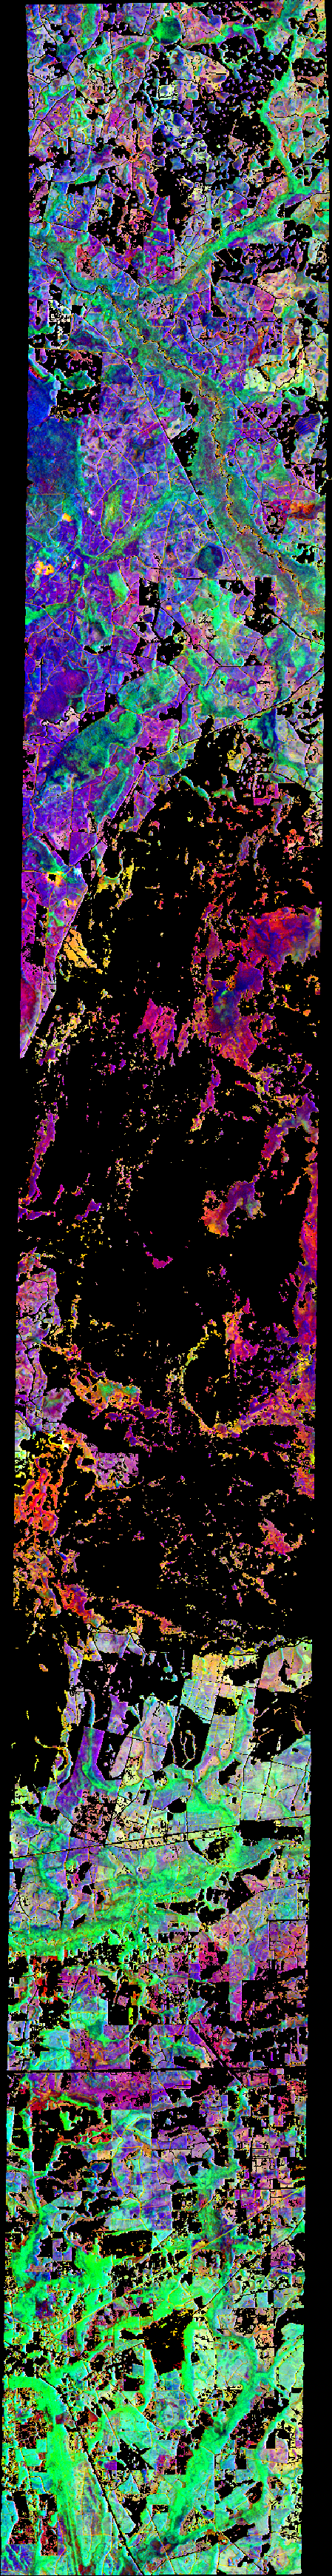

In [208]:
png = get_quicklook('f0f656f5-624c-455b-b14c-ab77268404d5')
IPython.display.Image(png)